In [81]:
import numpy as np
import random
import os
import math
from itertools import product

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler


from glob import glob
import pandas as pd
import cv2
from tqdm.auto import tqdm
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
# from torch.utils.tensorboard import SummaryWriter

from torch.autograd import Variable

import torchvision.models as models
from torchvision import transforms

import albumentations as A
import albumentations.pytorch

In [82]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")

Using cuda device


In [85]:
CFG = {
    'IMG_SIZE':256,
    'EPOCHS':10,
    'class':14
}

In [88]:
def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    
    image_path = os.path.join(data_dir, 'dessert')
    
    for product_name in os.listdir(image_path):
        product_path = os.path.join(image_path, product_name)
        if os.path.isdir(product_path):
            # get image path
            img_path_list.extend(glob(os.path.join(product_path, '*.jpg')))
            img_path_list.extend(glob(os.path.join(product_path, '*.png')))
            label = list(product_name[:5])
            
            # get label
            label_list.append(''.join(label))
                
    return img_path_list, label_list

In [89]:
img_list, label_list = get_train_data('/home/lab17/jupyter_home/Data/product_image/Training/')

In [90]:
# img_list

In [91]:
label_list

['55701',
 '45661',
 '35211',
 '45659',
 '25222',
 '35584',
 '55034',
 '45660',
 '35585',
 '45658',
 '55702',
 '45030',
 '45657',
 '25228']

In [92]:
def data_blanced(img, label):
    x = []
    y = []
    
    for i in range(CFG['class']):
        _img = img[(i * 114): ((i + 1) * 114)]
        _label = label[i]
        
        for img_product in _img:
            x.append(img_product)
            y.append(_label)
            
    return x, y

In [93]:
x, y = data_blanced(img_list, label_list)

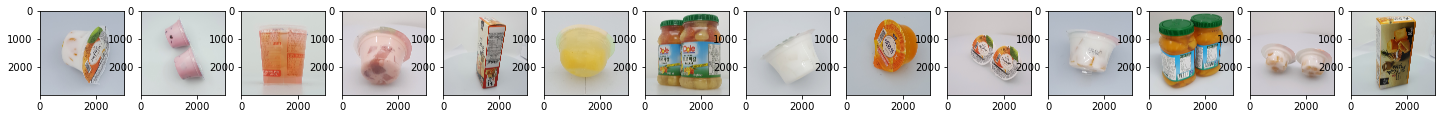

In [94]:
num_samples = CFG['class']
num = 2
i = 0

fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))

for a in ax:
    image = cv2.imread(x[i*114])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    a.imshow(image)
    i+=1
plt.show()


In [95]:
for i in range(CFG['class']):
    print(img_list[i*114][59:])

t/55701_쁘띠첼요거젤리밀감/55701_60_s_21.jpg
t/45661_씨제이)쁘티첼(요거젤리블루베리)/45661_60_m_18.jpg
t/35211_매일유업)데르뜨130G/35211_00_s_13.jpg
t/45659_씨제이)쁘티첼(요거젤리딸기)/45659_30_s_13.jpg
t/25222_대만)망고케익184g/25222_30_s_6.jpg
t/35584_매일데르뜨파인애플90G/35584_30_s_13.jpg
t/55034_돌트로피칼666G/55034_00_m_4.jpg
t/45660_씨제이)쁘티첼(요거젤리화이트코코)/45660_60_s_11.jpg
t/35585_매일데르뜨감귤90G/35585_60_s_5.jpg
t/45658_씨제이)쁘티첼(요거젤리밀감)/45658_30_m_5.jpg
t/55702_쁘띠첼요거젤리복숭아/55702_60_s_14.jpg
t/45030_돌황도666G/45030_30_m_11.jpg
t/45657_씨제이)쁘티첼(요거젤리복숭아)/45657_30_m_14.jpg
t/25228_대만)파인애플케익184G/25228_30_s_12.jpg


t/55701_쁘띠첼요거젤리밀감/55701_60_s_21.jpg


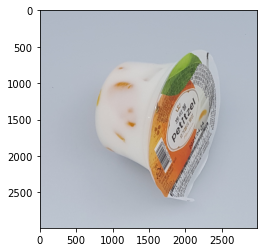

t/45661_씨제이)쁘티첼(요거젤리블루베리)/45661_60_m_18.jpg


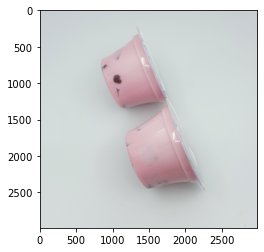

t/35211_매일유업)데르뜨130G/35211_00_s_13.jpg


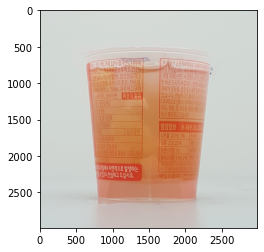

t/45659_씨제이)쁘티첼(요거젤리딸기)/45659_30_s_13.jpg


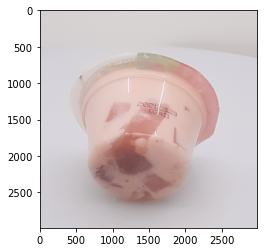

t/25222_대만)망고케익184g/25222_30_s_6.jpg


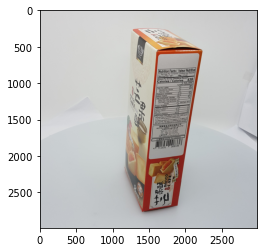

t/35584_매일데르뜨파인애플90G/35584_30_s_13.jpg


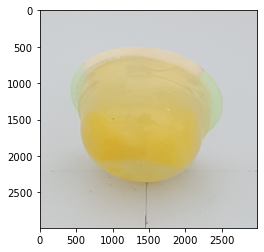

t/55034_돌트로피칼666G/55034_00_m_4.jpg


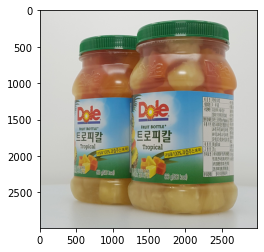

t/45660_씨제이)쁘티첼(요거젤리화이트코코)/45660_60_s_11.jpg


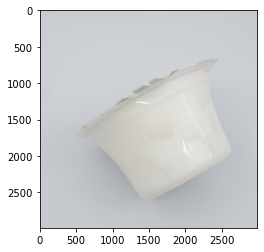

t/35585_매일데르뜨감귤90G/35585_60_s_5.jpg


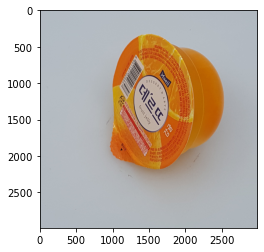

t/45658_씨제이)쁘티첼(요거젤리밀감)/45658_30_m_5.jpg


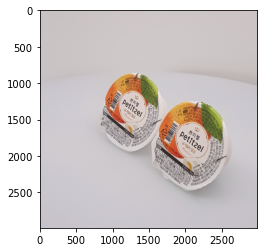

t/55702_쁘띠첼요거젤리복숭아/55702_60_s_14.jpg


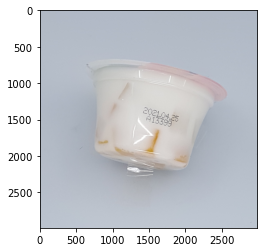

t/45030_돌황도666G/45030_30_m_11.jpg


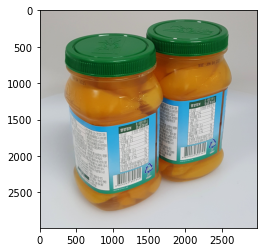

t/45657_씨제이)쁘티첼(요거젤리복숭아)/45657_30_m_14.jpg


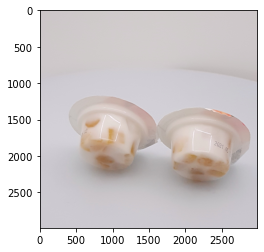

t/25228_대만)파인애플케익184G/25228_30_s_12.jpg


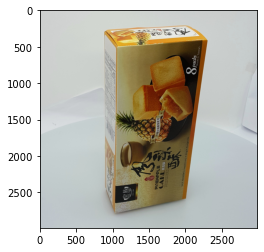

In [96]:
num_samples = CFG['class']
for i in range(num_samples):
    print(img_list[i*114][59:])
    image = cv2.imread(x[i*114])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()

In [97]:
# 레이블을 one-hot-vector로 변환
le = preprocessing.LabelEncoder()
targets = le.fit_transform(y)
targets = torch.as_tensor(targets)
one_hot_y = F.one_hot(targets)

In [98]:
one_hot_y.shape

torch.Size([1596, 14])

In [99]:
one_hot_y

tensor([[0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        ...,
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0]])

### Validation Data Loader

In [100]:
def get_valid_data(data_dir):
    img_valid_list = []
    label_valid_list = []
    
    image_path = os.path.join(data_dir, 'dessert')
    
    for product_name in os.listdir(image_path):
        product_path = os.path.join(image_path, product_name)
        if os.path.isdir(product_path):
            # get image path
            img_valid_list.extend(glob(os.path.join(product_path, '*.jpg')))
            img_valid_list.extend(glob(os.path.join(product_path, '*.png')))
            label = list(product_name[:5])
            
            # get label
            label_valid_list.append(''.join(label))
                
    return img_valid_list, label_valid_list

In [101]:
def valid_data_blanced(img, label):
    x = []
    y = []
    
    for i in range(CFG['class']):
        _img = img[(i * 15): ((i + 1) * 15)]
        _label = label[i]
        
        for img_product in _img:
            x.append(img_product)
            y.append(_label)
            
    return x, y

In [102]:
img_valid_list, label_valid_list = get_valid_data('/home/lab17/jupyter_home/Data/product_image/Validation/')
x_valid, y_valid = valid_data_blanced(img_valid_list, label_valid_list)
len(label_valid_list)

14

In [103]:
le2 = preprocessing.LabelEncoder()
targets_y = le2.fit_transform(y_valid)
targets_y = torch.as_tensor(targets_y)
one_hot_valid_y = F.one_hot(targets_y)
one_hot_valid_y.shape

torch.Size([210, 14])

# Augmentation

 - noramlize X

In [113]:
class AlbumentationsCustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None):
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        # Get image data
        image = cv2.imread(img_path)
        
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.train_mode:
#             image = image.astype(np.int16)
            augmented = self.transforms(image=image)
            image = augmented['image']
            label = self.label_list[index]
            return image, label
        else:
            image = self.transforms(image)
            label = self.label_list[index]
            return image, label
    
    def __len__(self):
        return len(self.img_path_list)

In [123]:
A_train_transform_normal = albumentations.Compose([
                                    A.Resize(256, 256),
#                                     albumentations.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                                    A.Normalize(mean=[0.747642, 0.737036, 0.713243],
                                                std=[0.1019, 0.121911, 0.169015]),
                                    A.RandomCrop(224, 224),
                                    A.RandomBrightness(limit=0.4, p=0.5),
                                    A.ShiftScaleRotate(rotate_limit=20, p=0.5, border_mode=cv2.BORDER_CONSTANT),
                                    A.pytorch.transforms.ToTensorV2(),
                                ])
A_test_transform_normal = albumentations.Compose([
                                    A.Resize(256, 256),
#                                     albumentations.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                                    A.Normalize(mean=[0.744859, 0.735139, 0.711357],
                                                std=[0.100712, 0.120692, 0.167998]),    
                                    A.pytorch.transforms.ToTensorV2()
                                ])

A_train_dataset = AlbumentationsCustomDataset(x, one_hot_y, train_mode=True, transforms=A_train_transform_normal)
A_train_loader = DataLoader(A_train_dataset, batch_size = 32, shuffle=True, num_workers=0, collate_fn=None)

A_vali_dataset = AlbumentationsCustomDataset(x_valid, one_hot_valid_y, train_mode=True, transforms=A_test_transform_normal)
A_vali_loader = DataLoader(A_vali_dataset, batch_size = 5, shuffle=False, num_workers=0, collate_fn=None)

In [124]:
### training 이미지

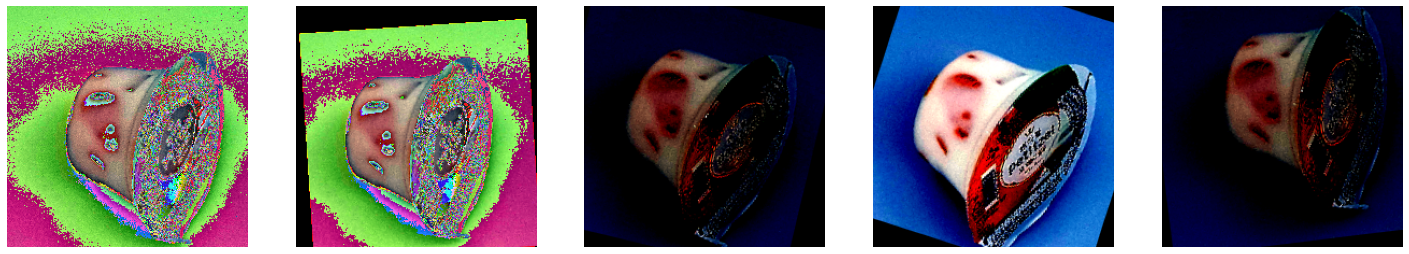

In [125]:
num_samples = 5

fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))

for i in range(num_samples):
    ax[i].imshow(transforms.ToPILImage()(A_train_dataset[0][0]))
    ax[i].axis('off')

### validation 이미지

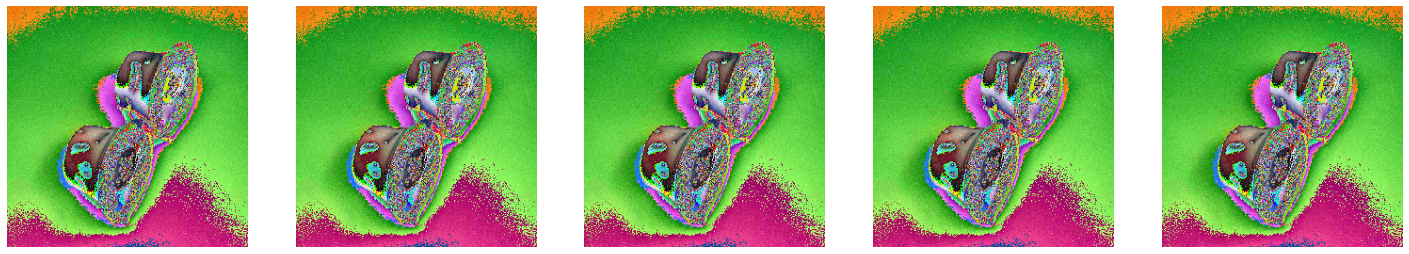

In [118]:
num_samples = 5

fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))

for i in range(num_samples):
    ax[i].imshow(transforms.ToPILImage()(A_vali_dataset[0][0]))
    ax[i].axis('off')

# Models

In [138]:
class ResNet50(torch.nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        model = models.resnet50(pretrained=True)
        modules = list(model.children())[:-1]
        self.feature_extract = nn.Sequential(*modules)
        self.fc1 = nn.Linear(2048, 1000)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1000,CFG['class'])
#         self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.feature_extract(x)
        # x = x.mean(dim=(-2, -1))
        # (batch, 2048, 4, 4)
        x = torch.squeeze(x)
        x = self.relu(self.fc1(x))
        out = self.fc2(x)
#         out = self.softmax(x)
        return out

In [139]:
class EfficientNetb4(torch.nn.Module):
    def __init__(self):
        super(EfficientNetb4, self).__init__()
        model = models.efficientnet_b4(pretrained=True)
        modules = list(model.children())[:-1]
        self.feature_extract = nn.Sequential(*modules)
        self.fc1 = nn.Linear(1792, 1000)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1000,CFG['class'])
#         self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.feature_extract(x)
        # (batch, 1792, 1, 1)
        x = torch.squeeze(x)
        x = self.relu(self.fc1(x))
        out = self.fc2(x)
#         out = self.softmax(x)
        return out

In [140]:
class RegNet(torch.nn.Module):
    def __init__(self):
        super(RegNet, self).__init__()
        model = models.regnet_y_16gf(pretrained=True)
        modules = list(model.children())[:-1]
        self.feature_extract = nn.Sequential(*modules)
        self.fc1 = nn.Linear(3024, 1000)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1000,CFG['class'])
#         self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.feature_extract(x)
        # (batch, 3024, 1, 1)
        x = torch.squeeze(x)
        x = self.relu(self.fc1(x))
        out = self.fc2(x)
#         out = self.softmax(x)
        return out

In [141]:
PARAMS = {
#     'models' : ['ResNet50', 'EfficientNetb4', 'RegNet'],
#     'learning_rate' : [1e-3, 1e-4, 1e-5],
#     'optimizer' : ['adam', 'rmsprop', 'nadam'],
    'models' : ['ResNet50', 'EfficientNetb4', 'RegNet'],
    'learning_rate' : [1e-3, 1e-4, 1e-5],
    'optimizer' : ['adam', 'rmsprop', 'nadam'],
}
hyper_params=list(product(PARAMS['models'], PARAMS['learning_rate'],PARAMS['optimizer']))

In [142]:
def draw_graph(title, loss, valid_loss):
    plt.plot(loss, label="Training Loss")
    plt.plot(valid_loss, label="Validation Loss")
    plt.legend(loc='upper right')
    plt.title(title)
    plt.savefig("./result/loss_chart/" + title + ".png")
    plt.show()

In [143]:
def validation(model, vali_loader, criterion, device, epoch):
    model.eval() # Evaluation
    vali_loss = []

    with torch.no_grad():
        for img, label in tqdm(iter(vali_loader)):
            img, label = img.float().to(device), label.float().to(device)

            logit = model(img)
            logit = torch.squeeze(logit)
            loss = criterion(logit, label)
            
            vali_loss.append(loss.item())

    vali_mae_loss = np.mean(vali_loss)
    return vali_mae_loss

In [144]:
def train(model, optimizer, train_loader, vali_loader, scheduler, device, params):
    
    model.to(device)
    epochs = 50
    
    loss_plot = []
    vali_loss_plot = []
    patience = 10
    earlystopping = 0

    # Loss Function
    criterion = torch.nn.CrossEntropyLoss()
    best_loss = 9999
    
    print("--------------------------------------------")
    print("model : {}".format(params[0]))
    print("optimizer : {}, learning rate : {}".format(params[2], params[1]))
    
    for epoch in range(1,epochs+1):
        model.train()
        train_loss = []
        for img, label in tqdm(iter(train_loader)):
            img, label = img.float().to(device), label.float().to(device)
            
            optimizer.zero_grad()

            # Data -> Model -> Output
            logit = model(img)
            logit = torch.squeeze(logit)
            # Calc loss
            loss = criterion(logit, label)
#             loss_plot.append(loss.item())

            # backpropagation
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            
        if scheduler is not None:
            scheduler.step()
            
        # Evaluation Validation set
        vali_loss = validation(model, vali_loader, criterion, device, epoch)
        loss_plot.append(np.mean(train_loss))
        vali_loss_plot.append(vali_loss)
        
        print(f'Epoch [{epoch}] Train loss : [{np.mean(train_loss):.5f}] Validation loss : [{vali_loss:.5f}]\n')
        
        # Model Saved
        if best_loss > vali_loss:
            best_loss = vali_loss
            torch.save(model.state_dict(), '/home/lab17/jupyter_home/saved_models/{}_{}_{}_example.pth'.format(params[0], params[1], params[2]))
            print('------------------ Model Saved ------------------')
            earlystopping = 0
        elif best_loss <= vali_loss:
            earlystopping += 1
            if earlystopping == patience:
                print("------------stop----------------")
                title = "{}_{}_{}_epoch_{}_loss".format(params[0], params[1], params[2], epoch)
                draw_graph(title, loss_plot, vali_loss_plot)
                break
                
        if epochs == epoch:
            title = "{}_{}_{}_epoch_{}_loss".format(params[0], params[1], params[2], epoch)
            draw_graph(title, loss_plot, vali_loss_plot)

--------------------------------------------
model : ResNet50
optimizer : adam, learning rate : 0.01


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [1] Train loss : [3.67931] Validation loss : [8.93642]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [2] Train loss : [2.51474] Validation loss : [2.19357]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [3] Train loss : [2.48762] Validation loss : [1.97305]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [4] Train loss : [2.34774] Validation loss : [1.96784]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [5] Train loss : [2.19224] Validation loss : [1.74296]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [6] Train loss : [2.04479] Validation loss : [2.17464]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [7] Train loss : [1.97287] Validation loss : [1.61343]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [8] Train loss : [1.93758] Validation loss : [1.63981]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [9] Train loss : [1.79096] Validation loss : [1.34088]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [10] Train loss : [1.67301] Validation loss : [1.59403]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [11] Train loss : [1.61258] Validation loss : [1.21352]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [12] Train loss : [1.57090] Validation loss : [1.52932]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [13] Train loss : [1.41193] Validation loss : [1.04900]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [14] Train loss : [1.33975] Validation loss : [1.38810]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [15] Train loss : [1.30636] Validation loss : [1.31113]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [16] Train loss : [1.22744] Validation loss : [1.05763]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [17] Train loss : [1.09751] Validation loss : [1.31033]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [18] Train loss : [1.08376] Validation loss : [1.00915]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [19] Train loss : [0.97861] Validation loss : [0.52311]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [20] Train loss : [0.89242] Validation loss : [2.26861]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [21] Train loss : [0.88378] Validation loss : [0.48841]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [22] Train loss : [0.79195] Validation loss : [0.53082]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [23] Train loss : [0.82133] Validation loss : [0.76326]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [24] Train loss : [0.68718] Validation loss : [0.33341]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [25] Train loss : [0.68859] Validation loss : [0.31862]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [26] Train loss : [0.66302] Validation loss : [0.49465]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [27] Train loss : [0.62579] Validation loss : [0.94647]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [28] Train loss : [0.62701] Validation loss : [0.52526]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [29] Train loss : [0.57400] Validation loss : [0.20725]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [30] Train loss : [0.57508] Validation loss : [1.35349]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [31] Train loss : [0.49631] Validation loss : [0.24051]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [32] Train loss : [0.47777] Validation loss : [0.31096]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [33] Train loss : [0.45840] Validation loss : [0.52607]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [34] Train loss : [0.39008] Validation loss : [0.13567]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [35] Train loss : [0.42898] Validation loss : [0.26696]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [36] Train loss : [0.42368] Validation loss : [0.34174]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [37] Train loss : [0.37962] Validation loss : [0.14376]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [38] Train loss : [0.36619] Validation loss : [0.53986]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [39] Train loss : [0.39059] Validation loss : [0.17555]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [40] Train loss : [0.34049] Validation loss : [0.11075]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [41] Train loss : [0.30962] Validation loss : [0.16641]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [42] Train loss : [0.37700] Validation loss : [0.77996]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [43] Train loss : [0.30800] Validation loss : [0.31777]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [44] Train loss : [0.30617] Validation loss : [0.54863]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [45] Train loss : [0.30645] Validation loss : [0.16574]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [46] Train loss : [0.25472] Validation loss : [0.03725]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [47] Train loss : [0.27715] Validation loss : [0.23082]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [48] Train loss : [0.27176] Validation loss : [0.07507]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [49] Train loss : [0.25518] Validation loss : [0.98590]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [50] Train loss : [0.30270] Validation loss : [0.29377]



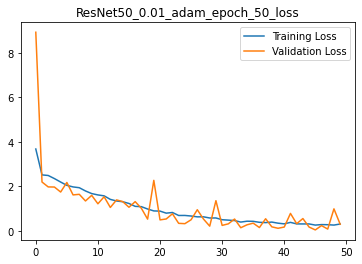

--------------------------------------------
model : ResNet50
optimizer : rmsprop, learning rate : 0.01


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [1] Train loss : [40.48962] Validation loss : [2.46437]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [2] Train loss : [2.59879] Validation loss : [2.61376]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [3] Train loss : [2.54917] Validation loss : [2.37936]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [4] Train loss : [2.49314] Validation loss : [2.26711]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [5] Train loss : [2.50805] Validation loss : [2.27068]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [6] Train loss : [2.48965] Validation loss : [2.32764]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [7] Train loss : [2.49127] Validation loss : [2.21811]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [8] Train loss : [2.47148] Validation loss : [2.07883]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [9] Train loss : [2.43875] Validation loss : [2.09950]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [10] Train loss : [2.37369] Validation loss : [1.98026]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [11] Train loss : [2.35162] Validation loss : [1.86423]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [12] Train loss : [2.36530] Validation loss : [2.25747]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [13] Train loss : [2.41429] Validation loss : [1.98293]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [14] Train loss : [2.36092] Validation loss : [2.03869]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [15] Train loss : [2.35530] Validation loss : [1.96586]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [16] Train loss : [2.29450] Validation loss : [2.02532]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [17] Train loss : [2.30405] Validation loss : [1.84429]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [18] Train loss : [2.28531] Validation loss : [6.43915]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [19] Train loss : [2.24542] Validation loss : [1.79258]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [20] Train loss : [2.14253] Validation loss : [2.09341]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [21] Train loss : [2.10515] Validation loss : [1.72588]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [22] Train loss : [1.90704] Validation loss : [1.97702]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [23] Train loss : [1.90595] Validation loss : [1.71357]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [24] Train loss : [1.76430] Validation loss : [1.29101]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [25] Train loss : [1.72585] Validation loss : [1.63108]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [26] Train loss : [1.66090] Validation loss : [1.29266]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [27] Train loss : [1.67997] Validation loss : [1.29887]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [28] Train loss : [1.57469] Validation loss : [1.05261]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [29] Train loss : [1.50301] Validation loss : [2.27406]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [30] Train loss : [1.31291] Validation loss : [0.97062]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [31] Train loss : [2.35941] Validation loss : [1.39999]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [32] Train loss : [1.65667] Validation loss : [1.45003]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [33] Train loss : [1.55496] Validation loss : [1.08435]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [34] Train loss : [1.53606] Validation loss : [1.67725]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [35] Train loss : [1.42151] Validation loss : [1.02523]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [36] Train loss : [1.32878] Validation loss : [0.88909]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [37] Train loss : [1.24369] Validation loss : [0.97435]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [38] Train loss : [1.22609] Validation loss : [1.22947]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [39] Train loss : [1.11146] Validation loss : [0.75413]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [40] Train loss : [0.98839] Validation loss : [1.38685]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [41] Train loss : [0.86709] Validation loss : [0.63083]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [42] Train loss : [0.94363] Validation loss : [0.47116]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [43] Train loss : [0.73196] Validation loss : [1.97236]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [44] Train loss : [0.70366] Validation loss : [0.42735]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [45] Train loss : [0.70799] Validation loss : [0.45902]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [46] Train loss : [0.91328] Validation loss : [0.35975]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [47] Train loss : [0.57152] Validation loss : [0.58416]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [48] Train loss : [0.68553] Validation loss : [0.36410]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [49] Train loss : [0.60674] Validation loss : [0.26958]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [50] Train loss : [0.57770] Validation loss : [0.22551]

------------------ Model Saved ------------------


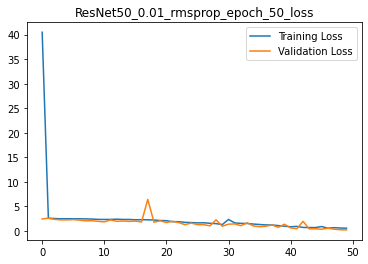

--------------------------------------------
model : ResNet50
optimizer : nadam, learning rate : 0.01


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [1] Train loss : [3.27952] Validation loss : [2.30640]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [2] Train loss : [2.49834] Validation loss : [2.30899]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [3] Train loss : [2.47987] Validation loss : [2.29367]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [4] Train loss : [2.42001] Validation loss : [1.96761]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [5] Train loss : [2.27736] Validation loss : [2.34004]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [6] Train loss : [2.20770] Validation loss : [1.74524]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [7] Train loss : [2.07359] Validation loss : [1.68004]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [8] Train loss : [2.08422] Validation loss : [1.72020]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [9] Train loss : [2.06862] Validation loss : [2.37194]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [10] Train loss : [2.04888] Validation loss : [1.54616]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [11] Train loss : [1.98765] Validation loss : [1.53102]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [12] Train loss : [1.89245] Validation loss : [2.19282]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [13] Train loss : [1.87379] Validation loss : [1.51819]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [14] Train loss : [1.75460] Validation loss : [2.21360]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [15] Train loss : [1.73565] Validation loss : [1.63400]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [16] Train loss : [1.59869] Validation loss : [1.97278]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [17] Train loss : [1.49179] Validation loss : [1.68594]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [18] Train loss : [1.34463] Validation loss : [1.86969]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [19] Train loss : [1.36132] Validation loss : [1.22912]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [20] Train loss : [1.21600] Validation loss : [1.14191]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [21] Train loss : [1.16715] Validation loss : [1.10007]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [22] Train loss : [1.11092] Validation loss : [2.50398]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [23] Train loss : [0.99931] Validation loss : [0.55899]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [24] Train loss : [0.84455] Validation loss : [0.80026]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [25] Train loss : [0.94551] Validation loss : [1.06891]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [26] Train loss : [0.81562] Validation loss : [0.50077]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [27] Train loss : [0.68309] Validation loss : [1.37063]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [28] Train loss : [0.71110] Validation loss : [1.09465]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [29] Train loss : [0.63951] Validation loss : [0.68203]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [30] Train loss : [0.58986] Validation loss : [2.68518]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [31] Train loss : [0.61897] Validation loss : [1.09863]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [32] Train loss : [0.50844] Validation loss : [0.36524]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [33] Train loss : [0.55933] Validation loss : [0.28480]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [34] Train loss : [0.50001] Validation loss : [0.85017]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [35] Train loss : [0.47386] Validation loss : [0.51148]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [36] Train loss : [0.47391] Validation loss : [0.41513]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [37] Train loss : [0.38743] Validation loss : [1.21229]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [38] Train loss : [0.42463] Validation loss : [1.67855]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [39] Train loss : [0.36873] Validation loss : [1.04304]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [40] Train loss : [0.32091] Validation loss : [0.18763]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [41] Train loss : [0.33197] Validation loss : [0.12528]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [42] Train loss : [0.35905] Validation loss : [0.29721]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [43] Train loss : [0.28091] Validation loss : [0.07708]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [44] Train loss : [0.35579] Validation loss : [1.34430]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [45] Train loss : [0.30317] Validation loss : [0.20846]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [46] Train loss : [0.26936] Validation loss : [0.08450]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [47] Train loss : [0.24319] Validation loss : [0.15537]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [48] Train loss : [0.27607] Validation loss : [0.15181]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [49] Train loss : [0.26515] Validation loss : [0.17000]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [50] Train loss : [0.24079] Validation loss : [0.29207]



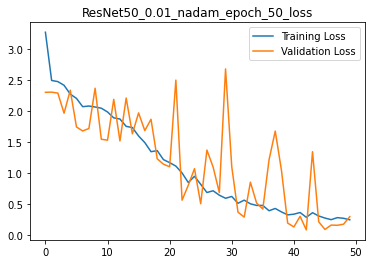

--------------------------------------------
model : ResNet50
optimizer : adam, learning rate : 0.001


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [1] Train loss : [1.60612] Validation loss : [1.64180]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [2] Train loss : [0.91744] Validation loss : [0.61422]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [3] Train loss : [0.81058] Validation loss : [0.80247]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [4] Train loss : [0.55162] Validation loss : [1.07563]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [5] Train loss : [0.56323] Validation loss : [0.47543]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [6] Train loss : [0.39274] Validation loss : [0.10945]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [7] Train loss : [0.40730] Validation loss : [0.20460]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [8] Train loss : [0.37551] Validation loss : [0.17822]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [9] Train loss : [0.32454] Validation loss : [0.13587]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [10] Train loss : [0.26467] Validation loss : [0.05756]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [11] Train loss : [0.28280] Validation loss : [0.15740]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [12] Train loss : [0.31475] Validation loss : [0.35838]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [13] Train loss : [0.29491] Validation loss : [0.25872]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [14] Train loss : [0.32780] Validation loss : [0.23730]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [15] Train loss : [0.32922] Validation loss : [0.20376]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [16] Train loss : [0.21101] Validation loss : [0.12372]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [17] Train loss : [0.22422] Validation loss : [0.04396]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [18] Train loss : [0.15835] Validation loss : [0.09568]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [19] Train loss : [0.18439] Validation loss : [0.02356]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [20] Train loss : [0.16493] Validation loss : [0.06998]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [21] Train loss : [0.17446] Validation loss : [0.04779]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [22] Train loss : [0.15295] Validation loss : [0.02791]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [23] Train loss : [0.16958] Validation loss : [0.03460]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [24] Train loss : [0.13871] Validation loss : [0.03800]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [25] Train loss : [0.16950] Validation loss : [0.00962]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [26] Train loss : [0.18463] Validation loss : [0.20754]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [27] Train loss : [0.19758] Validation loss : [0.01947]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [28] Train loss : [0.14223] Validation loss : [0.03977]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [29] Train loss : [0.18686] Validation loss : [0.03937]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [30] Train loss : [0.16624] Validation loss : [0.07273]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [31] Train loss : [0.11748] Validation loss : [0.01002]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [32] Train loss : [0.09177] Validation loss : [0.17983]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [33] Train loss : [0.15055] Validation loss : [0.05779]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [34] Train loss : [0.11420] Validation loss : [0.01124]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [35] Train loss : [0.14769] Validation loss : [0.06753]

------------stop----------------


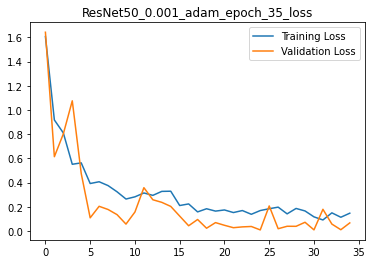

--------------------------------------------
model : ResNet50
optimizer : rmsprop, learning rate : 0.001


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [1] Train loss : [3.35417] Validation loss : [2.39606]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [2] Train loss : [2.52962] Validation loss : [2.32801]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [3] Train loss : [2.45487] Validation loss : [2.01286]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [4] Train loss : [2.27917] Validation loss : [1.81988]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [5] Train loss : [2.04786] Validation loss : [1.80478]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [6] Train loss : [1.88663] Validation loss : [1.47574]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [7] Train loss : [1.90080] Validation loss : [1.46492]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [8] Train loss : [1.69238] Validation loss : [1.98727]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [9] Train loss : [1.62257] Validation loss : [1.22354]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [10] Train loss : [1.47799] Validation loss : [2.20861]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [11] Train loss : [1.32850] Validation loss : [1.65192]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [12] Train loss : [1.17640] Validation loss : [0.78717]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [13] Train loss : [0.98374] Validation loss : [0.60705]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [14] Train loss : [0.96496] Validation loss : [0.56426]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [15] Train loss : [0.84155] Validation loss : [0.66995]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [16] Train loss : [0.73865] Validation loss : [1.80810]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [17] Train loss : [0.72031] Validation loss : [0.40449]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [18] Train loss : [0.65213] Validation loss : [0.59535]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [19] Train loss : [0.67031] Validation loss : [0.84093]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [20] Train loss : [0.56660] Validation loss : [0.28107]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [21] Train loss : [0.50095] Validation loss : [0.44212]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [22] Train loss : [0.51197] Validation loss : [1.57999]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [23] Train loss : [0.48016] Validation loss : [0.24882]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [24] Train loss : [0.37785] Validation loss : [0.14272]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [25] Train loss : [0.43952] Validation loss : [0.15705]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [26] Train loss : [0.39566] Validation loss : [0.10707]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [27] Train loss : [0.31202] Validation loss : [0.20217]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [28] Train loss : [0.37781] Validation loss : [0.20109]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [29] Train loss : [0.41559] Validation loss : [0.19421]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [30] Train loss : [0.27404] Validation loss : [0.11120]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [31] Train loss : [0.33405] Validation loss : [0.31247]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [32] Train loss : [0.31019] Validation loss : [0.09925]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [33] Train loss : [0.29282] Validation loss : [0.87535]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [34] Train loss : [0.30737] Validation loss : [0.06428]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [35] Train loss : [0.31007] Validation loss : [0.13626]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [36] Train loss : [0.25789] Validation loss : [1.00369]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [37] Train loss : [0.25700] Validation loss : [0.16964]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [38] Train loss : [0.24665] Validation loss : [0.33293]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [39] Train loss : [0.19152] Validation loss : [0.16407]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [40] Train loss : [0.25178] Validation loss : [0.65157]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [41] Train loss : [0.27964] Validation loss : [0.04857]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [42] Train loss : [0.19150] Validation loss : [0.01646]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [43] Train loss : [0.23162] Validation loss : [0.11015]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [44] Train loss : [0.18209] Validation loss : [0.04323]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [45] Train loss : [0.21656] Validation loss : [0.08539]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [46] Train loss : [0.20948] Validation loss : [1.07671]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [47] Train loss : [0.22202] Validation loss : [0.05338]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [48] Train loss : [0.25658] Validation loss : [0.04115]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [49] Train loss : [0.15386] Validation loss : [0.00727]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [50] Train loss : [0.17062] Validation loss : [0.05228]



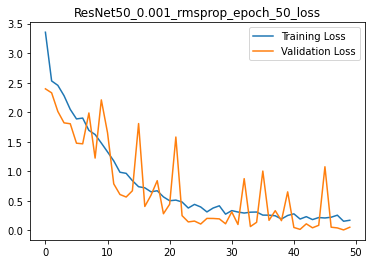

--------------------------------------------
model : ResNet50
optimizer : nadam, learning rate : 0.001


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [1] Train loss : [1.71233] Validation loss : [8.21742]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [2] Train loss : [0.92833] Validation loss : [2.59966]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [3] Train loss : [0.72752] Validation loss : [0.32208]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [4] Train loss : [0.48825] Validation loss : [0.87977]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [5] Train loss : [0.54061] Validation loss : [0.66453]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [6] Train loss : [0.38778] Validation loss : [0.10980]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [7] Train loss : [0.40943] Validation loss : [0.15956]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [8] Train loss : [0.27822] Validation loss : [1.16370]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [9] Train loss : [0.28416] Validation loss : [0.03362]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [10] Train loss : [0.21136] Validation loss : [0.06667]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [11] Train loss : [0.32892] Validation loss : [0.20256]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [12] Train loss : [0.23727] Validation loss : [0.23992]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [13] Train loss : [0.19179] Validation loss : [0.02816]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [14] Train loss : [0.18144] Validation loss : [0.04265]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [15] Train loss : [0.20180] Validation loss : [0.02946]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [16] Train loss : [0.16801] Validation loss : [0.18952]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [17] Train loss : [0.18666] Validation loss : [0.05420]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [18] Train loss : [0.24241] Validation loss : [0.03316]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [19] Train loss : [0.19896] Validation loss : [0.03012]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [20] Train loss : [0.15079] Validation loss : [0.32813]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [21] Train loss : [0.12664] Validation loss : [0.00887]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [22] Train loss : [0.12729] Validation loss : [0.02883]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [23] Train loss : [0.15031] Validation loss : [0.08815]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [24] Train loss : [0.15427] Validation loss : [0.06441]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [25] Train loss : [0.11762] Validation loss : [0.03795]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [26] Train loss : [0.19176] Validation loss : [1.81364]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [27] Train loss : [0.23304] Validation loss : [0.03838]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [28] Train loss : [0.12926] Validation loss : [0.06447]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [29] Train loss : [0.13714] Validation loss : [0.04331]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [30] Train loss : [0.11233] Validation loss : [0.04513]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [31] Train loss : [0.12175] Validation loss : [0.02707]

------------stop----------------


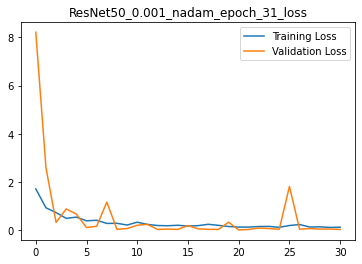

--------------------------------------------
model : ResNet50
optimizer : adam, learning rate : 0.0001


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [1] Train loss : [1.48444] Validation loss : [0.38194]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [2] Train loss : [0.26704] Validation loss : [0.08047]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [3] Train loss : [0.16097] Validation loss : [0.04242]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [4] Train loss : [0.09166] Validation loss : [0.01569]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [5] Train loss : [0.09666] Validation loss : [0.02615]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [6] Train loss : [0.07467] Validation loss : [0.01995]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [7] Train loss : [0.05601] Validation loss : [0.00824]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [8] Train loss : [0.05618] Validation loss : [0.02037]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [9] Train loss : [0.05768] Validation loss : [0.01099]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [10] Train loss : [0.04582] Validation loss : [0.00974]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [11] Train loss : [0.04908] Validation loss : [0.00571]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [12] Train loss : [0.05383] Validation loss : [0.04800]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [13] Train loss : [0.05331] Validation loss : [0.02676]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [14] Train loss : [0.09246] Validation loss : [0.02899]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [15] Train loss : [0.04693] Validation loss : [0.00741]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [16] Train loss : [0.02100] Validation loss : [0.01877]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [17] Train loss : [0.02489] Validation loss : [0.00378]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [18] Train loss : [0.02809] Validation loss : [0.00742]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [19] Train loss : [0.03492] Validation loss : [0.04122]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [20] Train loss : [0.01469] Validation loss : [0.00382]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [21] Train loss : [0.03992] Validation loss : [0.00324]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [22] Train loss : [0.04295] Validation loss : [0.03022]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [23] Train loss : [0.02108] Validation loss : [0.09142]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [24] Train loss : [0.01371] Validation loss : [0.00365]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [25] Train loss : [0.02359] Validation loss : [0.02354]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [26] Train loss : [0.05949] Validation loss : [0.01242]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [27] Train loss : [0.04149] Validation loss : [0.00590]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [28] Train loss : [0.07878] Validation loss : [0.38384]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [29] Train loss : [0.08693] Validation loss : [0.00986]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [30] Train loss : [0.03949] Validation loss : [0.00392]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [31] Train loss : [0.02560] Validation loss : [0.00490]

------------stop----------------


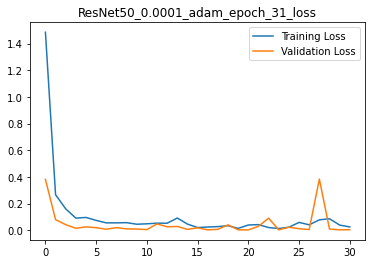

--------------------------------------------
model : ResNet50
optimizer : rmsprop, learning rate : 0.0001


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [1] Train loss : [1.16923] Validation loss : [0.23292]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [2] Train loss : [0.28229] Validation loss : [0.45525]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [3] Train loss : [0.15467] Validation loss : [0.04014]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [4] Train loss : [0.13174] Validation loss : [0.01514]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [5] Train loss : [0.08362] Validation loss : [0.02487]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [6] Train loss : [0.10828] Validation loss : [0.01785]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [7] Train loss : [0.07123] Validation loss : [0.04812]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [8] Train loss : [0.06097] Validation loss : [0.43262]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [9] Train loss : [0.07493] Validation loss : [0.08593]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [10] Train loss : [0.07012] Validation loss : [0.01067]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [11] Train loss : [0.06747] Validation loss : [0.00309]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [12] Train loss : [0.03524] Validation loss : [0.00343]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [13] Train loss : [0.04556] Validation loss : [0.03881]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [14] Train loss : [0.09898] Validation loss : [0.01469]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [15] Train loss : [0.03916] Validation loss : [0.00248]

------------------ Model Saved ------------------


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [16] Train loss : [0.05307] Validation loss : [0.00758]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [17] Train loss : [0.04229] Validation loss : [0.05882]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [18] Train loss : [0.04647] Validation loss : [0.04006]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [19] Train loss : [0.06227] Validation loss : [0.07512]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [20] Train loss : [0.03571] Validation loss : [0.00769]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [21] Train loss : [0.01609] Validation loss : [0.01442]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [22] Train loss : [0.05724] Validation loss : [0.30183]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [23] Train loss : [0.02580] Validation loss : [0.00565]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [24] Train loss : [0.01266] Validation loss : [0.00601]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [25] Train loss : [0.07499] Validation loss : [0.01023]

------------stop----------------


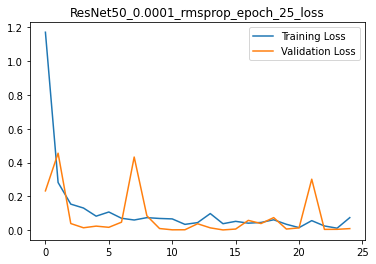

--------------------------------------------
model : ResNet50
optimizer : nadam, learning rate : 0.0001


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
'''
    'models' : ['ResNet50', 'EfficientNetb4', 'RegNet'],
    'learning_rate' : [1e-3, 1e-4, 1e-5],
    'optimizer' : ['adam', 'rmsprop', 'nadam'],
'''
# resnet -3, -4(1,2)
# regnet -5


for params in hyper_params:
    
    scheduler = None
    
    # model
    if params[0] == 'ResNet50':
        model = ResNet50()
            # optimizer
        if params[1] in [1e-3]: pass
        elif params[1] in [1e-4]:
            if params[2] == 'nadam':
                optimizer = torch.optim.NAdam(model.parameters(), lr=params[1])
            else : pass
            train(model, optimizer, A_train_loader, A_vali_loader, scheduler, device, params)
        else:
            if params[2] == 'adam':
                optimizer = torch.optim.Adam(model.parameters(), lr=params[1])
            elif params[2] == 'rmsprop':
                optimizer = torch.optim.RMSprop(model.parameters(), lr=params[1])
            elif params[2] == 'nadam':
                optimizer = torch.optim.NAdam(model.parameters(), lr=params[1])
            
    
            train(model, optimizer, A_train_loader, A_vali_loader, scheduler, device, params)

        
        
    elif params[0] == 'EfficientNetb4':
        model = EfficientNetb4()
            # optimizer
        if params[2] == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=params[1])
        elif params[2] == 'rmsprop':
            optimizer = torch.optim.RMSprop(model.parameters(), lr=params[1])
        elif params[2] == 'nadam':
            optimizer = torch.optim.NAdam(model.parameters(), lr=params[1])
            
        train(model, optimizer, A_train_loader, A_vali_loader, scheduler, device, params)

        
    elif params[0] == 'RegNet':
        model = RegNet()
        if params[2] == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=params[1])
        elif params[2] == 'rmsprop':
            optimizer = torch.optim.RMSprop(model.parameters(), lr=params[1])
        elif params[2] == 'nadam':
            optimizer = torch.optim.NAdam(model.parameters(), lr=params[1])
            
        train(model, optimizer, A_train_loader, A_vali_loader, scheduler, device, params)

## Predict

In [ ]:
class ResNet50(torch.nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        model = models.resnet50(pretrained=True)
        modules = list(model.children())[:-1]
        self.feature_extract = nn.Sequential(*modules)
        self.fc1 = nn.Linear(2048, 1000)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1000,CFG['class'])
#         self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.feature_extract(x)
        # x = x.mean(dim=(-2, -1))
        # (batch, 2048, 4, 4)
        x = torch.squeeze(x)
        x = self.relu(self.fc1(x))
        out = self.fc2(x)
#         out = self.softmax(x)
        return out

In [ ]:
pred_ensemble = []
batch_size = 34
# Test
test_dataset = Custom_dataset(np.array(test_imgs), np.array(["tmp"]*len(test_imgs)), mode='test')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

model_test = ResNet50
model_test.load_state_dict(torch.load('/home/lab17/jupyter_home/saved_models/{}_{}_{}_example.pth'.format(0,1,2))['state_dict'])
model_test.eval()
# f_pred = []
# pred_prob = []

image_data = Image.open('home/lab17/jupyter_home/Data/product_test/img.jpg')

image_transform = transforms.Compose([
    transforms.Resize(size=256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.744859, 0.735139, 0.711357],
                         std=[0.100712, 0.120692, 0.167998])
])

x = image_transform(image_data)
pred = model_test(x)
pred_prob.extend(pred.detach().cpu().numpy())
f_pred.extend(pred.argmax(1).detach().cpu().numpy().tolist())

label_decoder = {val:key for key, val in label_unique.items()}

f_result = [label_decoder[result] for result in f_pred]

print(f_result)